Epoch 1/50, Train Loss: 0.9755, Train Acc: 66.96%, Val Loss: 0.8099, Val Acc: 71.88%


c:\Users\junwe\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 2/50, Train Loss: 0.3329, Train Acc: 88.10%, Val Loss: 0.4444, Val Acc: 84.38%
Epoch 3/50, Train Loss: 0.2054, Train Acc: 92.86%, Val Loss: 0.1877, Val Acc: 96.88%
Epoch 4/50, Train Loss: 0.2056, Train Acc: 94.64%, Val Loss: 0.1595, Val Acc: 95.83%
Epoch 5/50, Train Loss: 0.1272, Train Acc: 96.73%, Val Loss: 0.1708, Val Acc: 94.79%
Epoch 6/50, Train Loss: 0.2110, Train Acc: 94.94%, Val Loss: 0.5408, Val Acc: 83.33%
Epoch 7/50, Train Loss: 0.1612, Train Acc: 94.35%, Val Loss: 0.1482, Val Acc: 95.83%
Epoch 8/50, Train Loss: 0.0670, Train Acc: 98.51%, Val Loss: 0.2304, Val Acc: 94.79%
Epoch 9/50, Train Loss: 0.0680, Train Acc: 97.32%, Val Loss: 0.1117, Val Acc: 95.83%
Epoch 10/50, Train Loss: 0.0888, Train Acc: 97.32%, Val Loss: 0.3581, Val Acc: 91.67%
Epoch 11/50, Train Loss: 0.1485, Train Acc: 96.13%, Val Loss: 0.1688, Val Acc: 93.75%
Epoch 12/50, Train Loss: 0.0606, Train Acc: 98.51%, Val Loss: 0.2740, Val Acc: 88.54%
Epoch 13/50, Train Loss: 0.0911, Train Acc: 96.13%, Val Loss: 

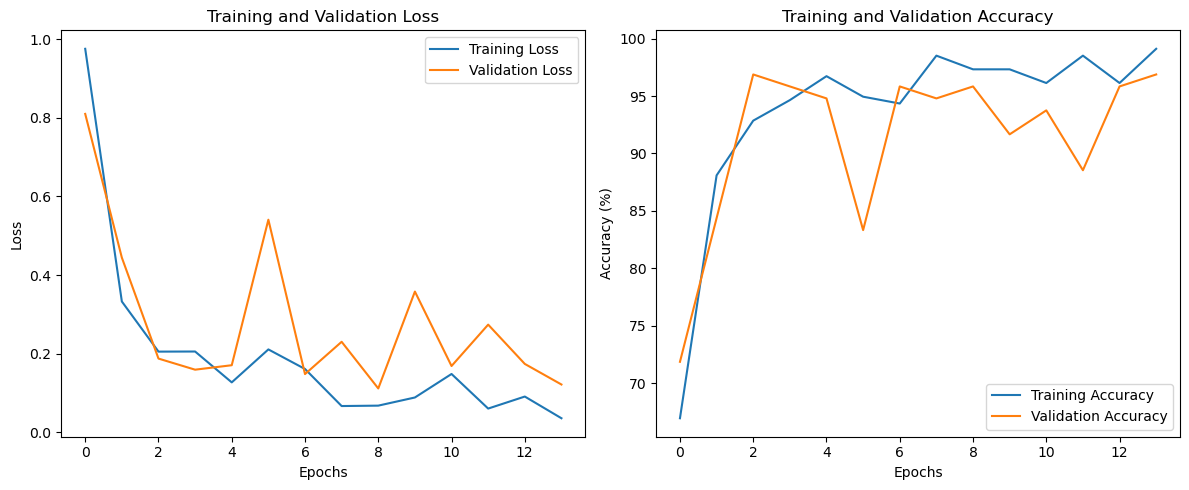


Classification Report on Test Set:
              precision    recall  f1-score   support

      glioma     0.9167    1.0000    0.9565        11
  meningioma     0.9000    0.9000    0.9000        10
     notumor     1.0000    0.7857    0.8800        14
   pituitary     0.8667    1.0000    0.9286        13

    accuracy                         0.9167        48
   macro avg     0.9208    0.9214    0.9163        48
weighted avg     0.9240    0.9167    0.9149        48


Overall Accuracy on Test Set: 91.67%


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.models import resnet50, ResNet50_Weights
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import multiprocessing

class BrainMRIResNet(nn.Module):
    def __init__(self, num_classes=4):
        super(BrainMRIResNet, self).__init__()
        self.resnet = resnet50(weights=ResNet50_Weights.DEFAULT)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.3),  # Reduced dropout
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        return self.resnet(x)

def train_and_evaluate_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device, patience=5):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss /= len(val_loader)
        val_accuracy = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        
        # Save the best model and check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_brain_mri_model.pth')
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f"Early stopping triggered after epoch {epoch+1}")
                break

    return train_losses, val_losses, train_accuracies, val_accuracies

if __name__ == '__main__':
    multiprocessing.freeze_support()

    # 1. Data preparation
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Load the full dataset
    full_dataset = torchvision.datasets.ImageFolder(root='../dataset_26', transform=transform)

    # Split the dataset into train, validation, and test sets
    total_size = len(full_dataset)
    train_size = int(0.7 * total_size)
    val_size = int(0.2 * total_size)
    test_size = total_size - train_size - val_size

    train_dataset, val_dataset, test_dataset = random_split(
        full_dataset, 
        [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )

    num_workers = min(4, multiprocessing.cpu_count())

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=num_workers)

    class_names = full_dataset.classes

    # 2. Model architecture
    model = BrainMRIResNet(num_classes=4)

    # 3. Training setup
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # Reduced weight decay
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
    
    # New learning rate scheduler
    num_epochs = 20
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, epochs=num_epochs, steps_per_epoch=len(train_loader))

    # 4. Training loop
    num_epochs = 50  # Increased max epochs, but we'll likely stop earlier due to early stopping
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses, val_losses, train_accuracies, val_accuracies = train_and_evaluate_model(
        model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device
    )

    # 5. Visualization
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # 6. Test Set Evaluation
    model.load_state_dict(torch.load('best_brain_mri_model.pth'))
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Print classification report
    print("\nClassification Report on Test Set:")
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

    # Calculate overall accuracy
    accuracy = (100.0 * sum([1 for p, t in zip(all_preds, all_labels) if p == t])) / len(all_preds)
    print(f"\nOverall Accuracy on Test Set: {accuracy:.2f}%")